In [177]:
import pandas as pd
import numpy as npt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
import datetime
import re
from imblearn.over_sampling import SMOTE

In [101]:
def add_datepart(df, fldname, drop=True, time=False, errors="raise"):	
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.
    Examples:
    ---------
    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df
        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13
    >>> add_datepart(df, 'A')
    >>> df
        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)
        
        
def train_cats(df):
    """Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [102]:
df = pd.read_csv("./train/train.csv")
df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [82]:
# df_raw = df[:20000].copy()

In [103]:
df_raw = df.copy()

In [104]:
df_raw.shape

(237609, 7)

In [105]:
df_raw.drop('impression_id', axis=1, inplace=True)
df_raw['os_version'] = df_raw['os_version'].astype('category').cat.codes
df_raw['is_4G'] = df_raw['is_4G'].astype('category').cat.codes
df_raw['is_click'] = df_raw['is_click'].astype('category').cat.codes

add_datepart(df_raw, 'impression_time')
df_raw.head()

,user_id,app_code,os_version,is_4G,is_click,impression_timeYear,impression_timeMonth,impression_timeWeek,impression_timeDay,impression_timeDayofweek,impression_timeDayofyear,impression_timeIs_month_end,impression_timeIs_month_start,impression_timeIs_quarter_end,impression_timeIs_quarter_start,impression_timeIs_year_end,impression_timeIs_year_start,impression_timeElapsed
0,87862,422,2,0,0,2018,11,46,15,3,319,False,False,False,False,False,False,1542240000
1,63410,467,1,1,1,2018,11,46,15,3,319,False,False,False,False,False,False,1542240060
2,71748,259,0,1,0,2018,11,46,15,3,319,False,False,False,False,False,False,1542240120
3,69209,244,1,1,0,2018,11,46,15,3,319,False,False,False,False,False,False,1542240120
4,62873,473,1,0,0,2018,11,46,15,3,319,False,False,False,False,False,False,1542240120


In [106]:
df_raw.dtypes

user_id                            int64
app_code                           int64
os_version                          int8
is_4G                               int8
is_click                            int8
impression_timeYear                int64
impression_timeMonth               int64
impression_timeWeek                int64
impression_timeDay                 int64
impression_timeDayofweek           int64
impression_timeDayofyear           int64
impression_timeIs_month_end         bool
impression_timeIs_month_start       bool
impression_timeIs_quarter_end       bool
impression_timeIs_quarter_start     bool
impression_timeIs_year_end          bool
impression_timeIs_year_start        bool
impression_timeElapsed             int64
dtype: object

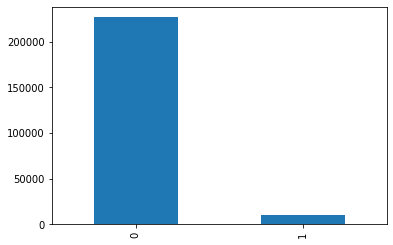

In [107]:
df_raw['is_click'].value_counts()
pd.value_counts(df_raw['is_click']).plot.bar()

In [108]:
y_raw = df_raw['is_click']
df_raw.drop('is_click', axis=1, inplace=True)

In [159]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 170106, 1: 8100}

In [109]:
x_train, x_test, y_train, y_test = train_test_split(df_raw, y_raw)

In [156]:
sm = SMOTE(random_state=2)
x_train_smote, y_train_smote = sm.fit_resample(x_train, y_train)

In [178]:
train = lgb.Dataset(x_train, label=y_train)
test = lgb.Dataset(x_test, label=y_test)

In [179]:
params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'auc'
params['sub_feature'] = 0.8
params['num_leaves'] = 50
params['min_data'] = 50
params['max_depth'] = 10

bst = lgb.train(params, train_set=train, valid_sets=[test], 
                  num_boost_round=200)

[1]	valid_0's auc: 0.525289
[2]	valid_0's auc: 0.682679
[3]	valid_0's auc: 0.685325
[4]	valid_0's auc: 0.686994
[5]	valid_0's auc: 0.686394
[6]	valid_0's auc: 0.684665
[7]	valid_0's auc: 0.682481
[8]	valid_0's auc: 0.684427
[9]	valid_0's auc: 0.682372
[10]	valid_0's auc: 0.684041
[11]	valid_0's auc: 0.685061
[12]	valid_0's auc: 0.685675
[13]	valid_0's auc: 0.685865
[14]	valid_0's auc: 0.686282
[15]	valid_0's auc: 0.686427
[16]	valid_0's auc: 0.686195
[17]	valid_0's auc: 0.686992
[18]	valid_0's auc: 0.686974
[19]	valid_0's auc: 0.686965
[20]	valid_0's auc: 0.687459
[21]	valid_0's auc: 0.687767
[22]	valid_0's auc: 0.687991
[23]	valid_0's auc: 0.687725
[24]	valid_0's auc: 0.68825
[25]	valid_0's auc: 0.688263
[26]	valid_0's auc: 0.688579
[27]	valid_0's auc: 0.688707
[28]	valid_0's auc: 0.689119
[29]	valid_0's auc: 0.689158
[30]	valid_0's auc: 0.689066
[31]	valid_0's auc: 0.689144
[32]	valid_0's auc: 0.689147
[33]	valid_0's auc: 0.689229
[34]	valid_0's auc: 0.689163
[35]	valid_0's auc: 0.68

In [171]:
df_test = pd.read_csv("./test/test.csv")
df_test.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,22988,207,latest,1
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,35431,242,latest,1


In [172]:
df_raw = df_test.copy()

In [173]:
submit = pd.DataFrame()
submit['impression_id'] = df_raw['impression_id']

In [174]:
df_raw.drop('impression_id', axis=1, inplace=True)
df_raw['os_version'] = df_raw['os_version'].astype('category').cat.codes
df_raw['is_4G'] = df_raw['is_4G'].astype('category').cat.codes

add_datepart(df_raw, 'impression_time')
df_raw.head()

,user_id,app_code,os_version,is_4G,impression_timeYear,impression_timeMonth,impression_timeWeek,impression_timeDay,impression_timeDayofweek,impression_timeDayofyear,impression_timeIs_month_end,impression_timeIs_month_start,impression_timeIs_quarter_end,impression_timeIs_quarter_start,impression_timeIs_year_end,impression_timeIs_year_start,impression_timeElapsed
0,44754,127,1,1,2018,12,50,13,3,347,False,False,False,False,False,False,1544687040
1,29656,44,1,0,2018,12,50,13,3,347,False,False,False,False,False,False,1544687100
2,25234,296,1,1,2018,12,50,13,3,347,False,False,False,False,False,False,1544687160
3,22988,207,1,1,2018,12,50,13,3,347,False,False,False,False,False,False,1544687220
4,35431,242,1,1,2018,12,50,13,3,347,False,False,False,False,False,False,1544687280


In [175]:
submit['is_click'] = bst.predict(df_raw)

In [176]:
submit.to_csv("Ooof.csv", index=False)